In [1]:
pip install imbalanced-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_csv('/content/penguins.csv')
df.head(5)

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female


----- Info Data -----
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   species            344 non-null    object 
 1   island             344 non-null    object 
 2   bill_length_mm     342 non-null    float64
 3   bill_depth_mm      342 non-null    float64
 4   flipper_length_mm  342 non-null    float64
 5   body_mass_g        342 non-null    float64
 6   sex                333 non-null    object 
dtypes: float64(4), object(3)
memory usage: 18.9+ KB
None

----- Statistik Deskriptif -----
       bill_length_mm  bill_depth_mm  flipper_length_mm  body_mass_g
count      342.000000     342.000000         342.000000   342.000000
mean        43.921930      17.151170         200.915205  4201.754386
std          5.459584       1.974793          14.061714   801.954536
min         32.100000      13.100000         172.000000  2700.000000
25%  

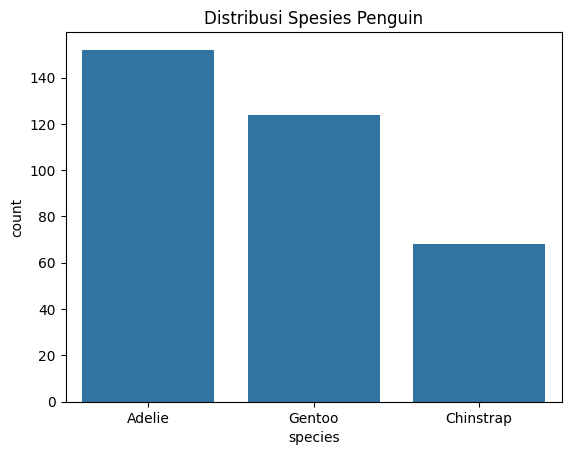

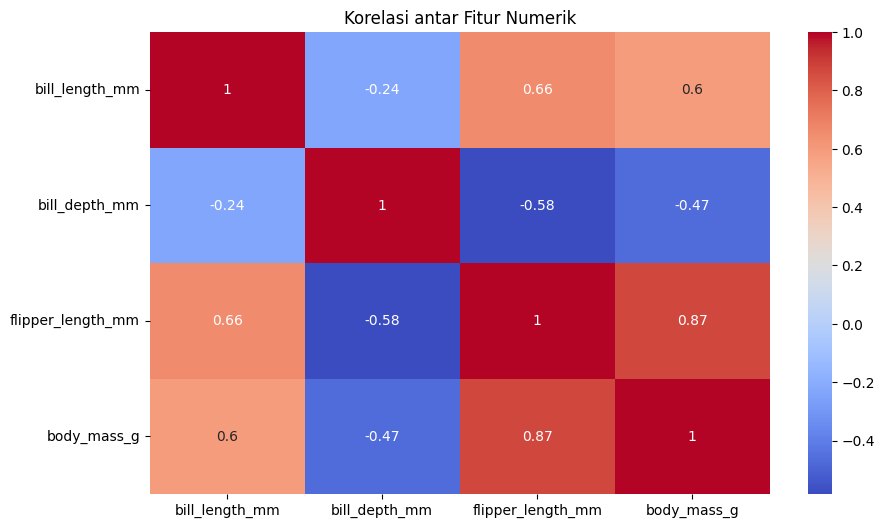

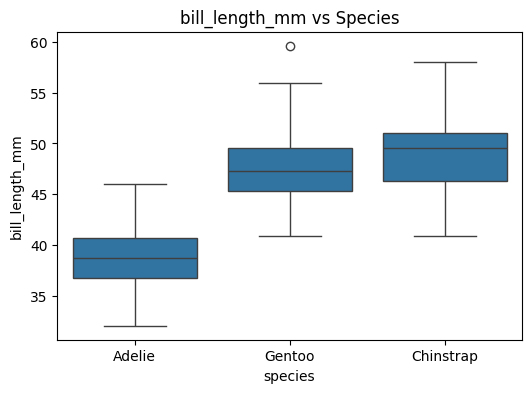

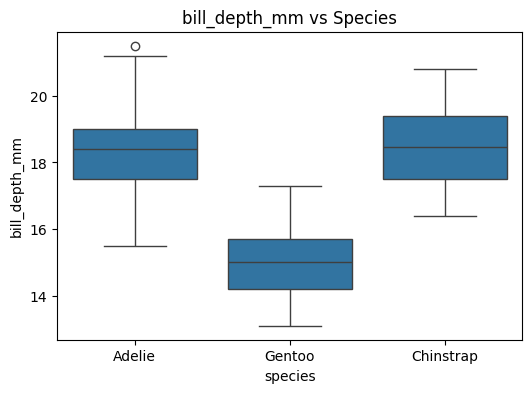

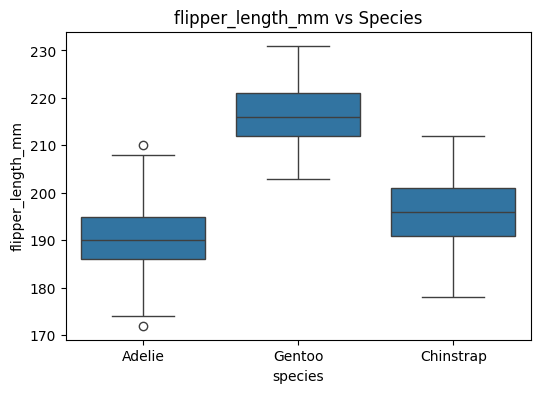

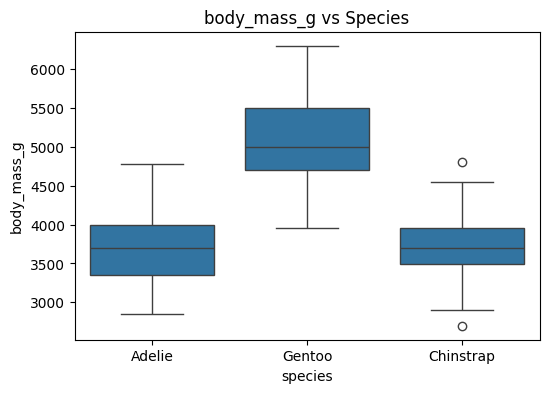

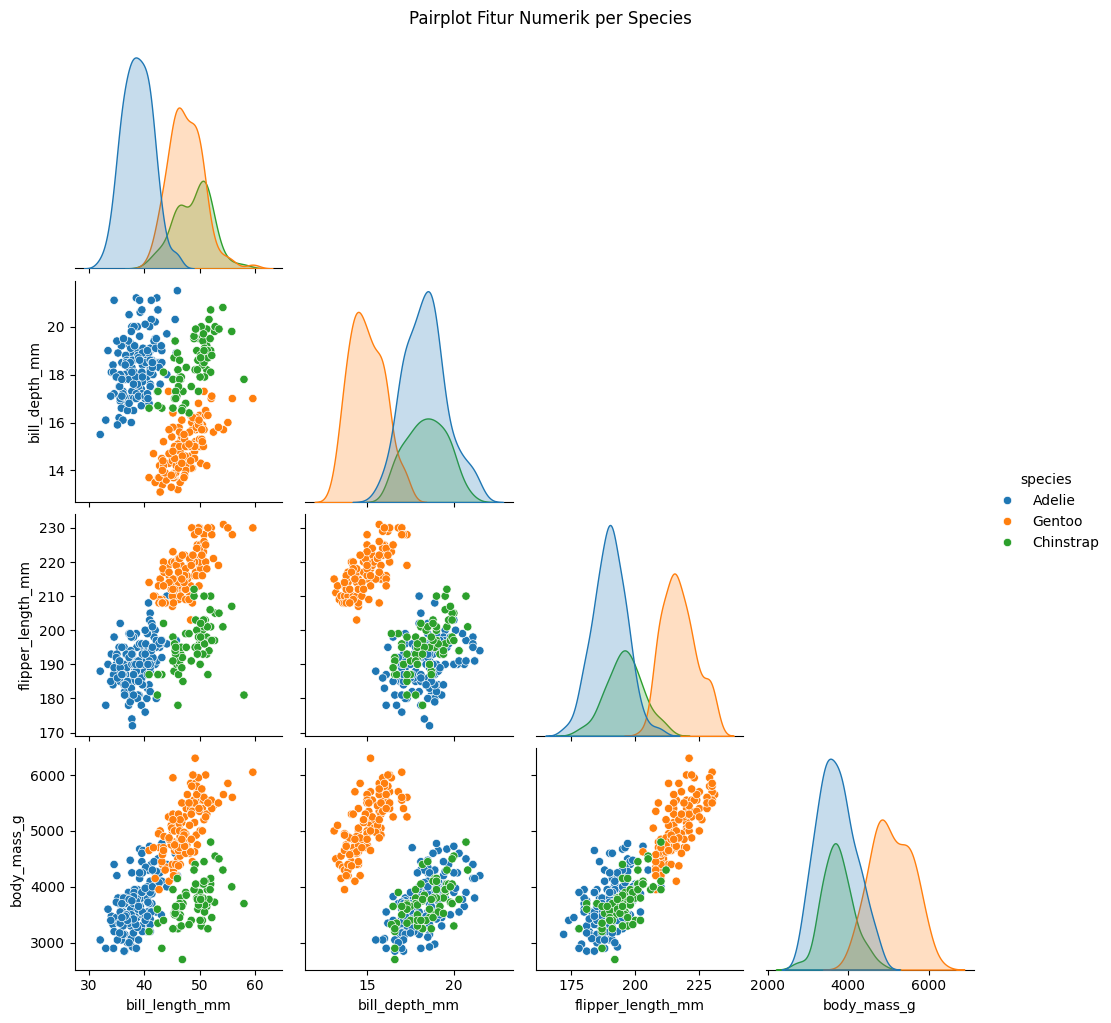

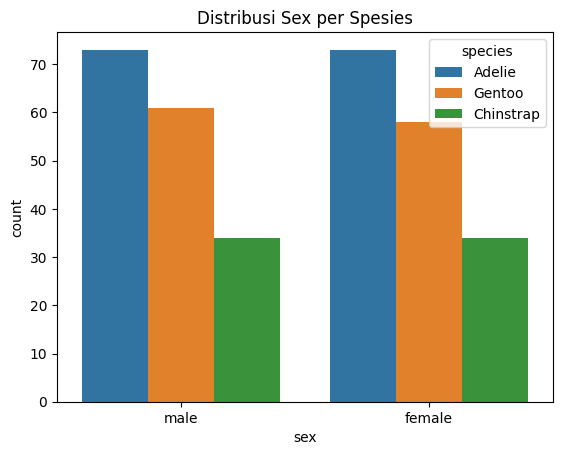

In [4]:
# EDA
# -------------------------------------
print("----- Info Data -----")
print(df.info())
print("\n----- Statistik Deskriptif -----")
print(df.describe())

sns.countplot(data=df, x='species')
plt.title("Distribusi Spesies Penguin")
plt.show()

plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes(include='number').corr(), annot=True, cmap='coolwarm')
plt.title("Korelasi antar Fitur Numerik")
plt.show()

num_cols = ['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm', 'body_mass_g']
for col in num_cols:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=df, x='species', y=col)
    plt.title(f"{col} vs Species")
    plt.show()

sns.pairplot(df, hue="species", vars=num_cols, corner=True)
plt.suptitle("Pairplot Fitur Numerik per Species", y=1.02)
plt.show()

sns.countplot(data=df, x='sex', hue='species')
plt.title("Distribusi Sex per Spesies")
plt.show()

In [5]:
# 1. HANDLE OUTLIERS (IQR)
# -------------------------------------
for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

In [6]:
# 2. IMPUTASI MISSING VALUES
# -------------------------------------
imputer = KNNImputer(n_neighbors=5)
df[num_cols] = imputer.fit_transform(df[num_cols])

In [7]:
# 3. ENCODING
# -------------------------------------
df_encoded = pd.get_dummies(df, columns=['island', 'sex'])
le = LabelEncoder()
df_encoded['species'] = le.fit_transform(df_encoded['species'])

In [9]:
# 4. SPLIT FITUR & TARGET
# -------------------------------------
X = df_encoded.drop('species', axis=1)
y = df_encoded['species']

# Stratify supaya distribusi seimbang di train-test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [10]:
# 5. SMOTE UNTUK BALANCE DATA
# -------------------------------------
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

In [11]:
# 6. SCALING
# -------------------------------------
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_bal)
X_test_scaled = scaler.transform(X_test)

In [14]:
# 7. MODELING & EVALUASI
# -------------------------------------
models = {
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

print("\n===== Akurasi Model Setelah SMOTE dan Scaling =====")
for name, model in models.items():
    model.fit(X_train_scaled, y_train_bal)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc:.4f}")


===== Akurasi Model Setelah SMOTE dan Scaling =====
Decision Tree: 0.9855
Random Forest: 1.0000
K-Nearest Neighbors: 1.0000



===== Akurasi Model Setelah SMOTE dan Scaling =====

📌 Decision Tree
Akurasi: 0.9855


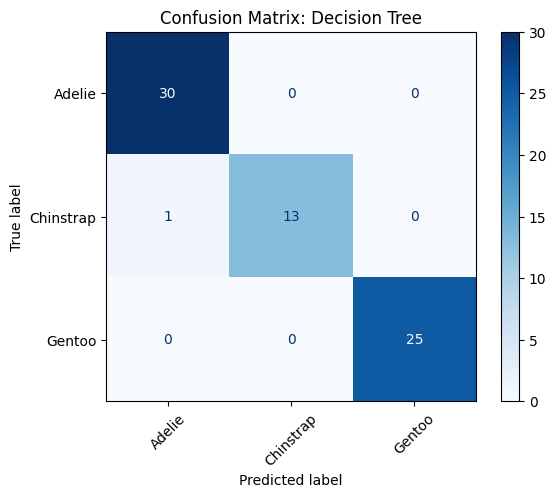

Classification Report:
              precision    recall  f1-score   support

      Adelie       0.97      1.00      0.98        30
   Chinstrap       1.00      0.93      0.96        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           0.99        69
   macro avg       0.99      0.98      0.98        69
weighted avg       0.99      0.99      0.99        69


📌 Random Forest
Akurasi: 1.0000


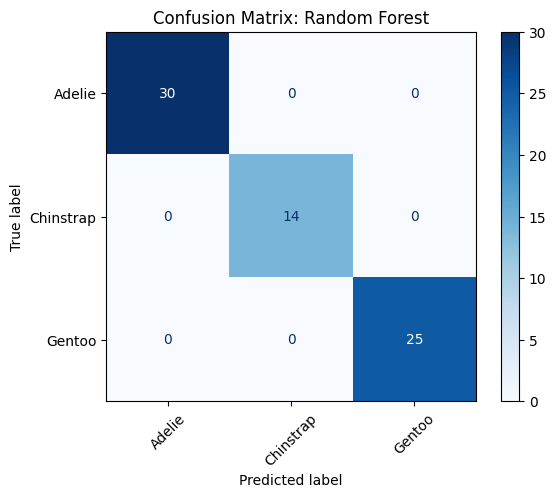

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69


📌 K-Nearest Neighbors
Akurasi: 1.0000


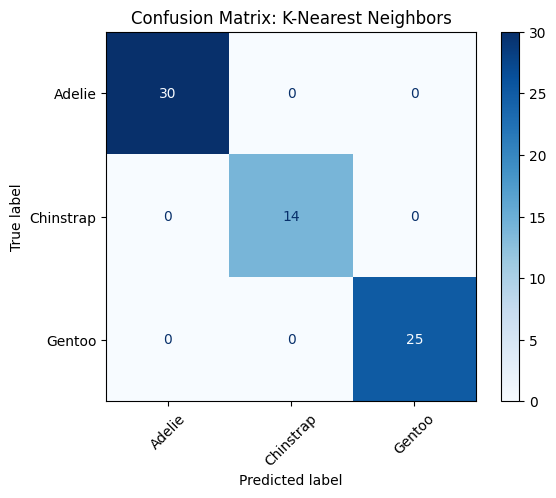

Classification Report:
              precision    recall  f1-score   support

      Adelie       1.00      1.00      1.00        30
   Chinstrap       1.00      1.00      1.00        14
      Gentoo       1.00      1.00      1.00        25

    accuracy                           1.00        69
   macro avg       1.00      1.00      1.00        69
weighted avg       1.00      1.00      1.00        69



In [15]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

print("\n===== Akurasi Model Setelah SMOTE dan Scaling =====")
for name, model in models.items():
    model.fit(X_train_scaled, y_train_bal)
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    print(f"\n📌 {name}")
    print(f"Akurasi: {acc:.4f}")

    # Confusion Matrix
    disp = ConfusionMatrixDisplay.from_predictions(
        y_test, y_pred,
        display_labels=le.classes_,
        cmap='Blues',
        xticks_rotation=45
    )
    disp.ax_.set_title(f'Confusion Matrix: {name}')
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

In [16]:
from sklearn.model_selection import cross_val_score

print("\n===== Cross Validation (5-fold) =====")
for name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train_bal, cv=5)
    print(f"{name}: Mean CV Accuracy = {scores.mean():.4f} | Std = {scores.std():.4f}")


===== Cross Validation (5-fold) =====
Decision Tree: Mean CV Accuracy = 0.9726 | Std = 0.0287
Random Forest: Mean CV Accuracy = 0.9918 | Std = 0.0067
K-Nearest Neighbors: Mean CV Accuracy = 0.9917 | Std = 0.0067


In [17]:
import joblib

# Simpan model
joblib.dump(models["Random Forest"], "model_penguin.pkl")

# Simpan scaler juga (penting untuk transform input user di web)
joblib.dump(scaler, "scaler_penguin.pkl")

# Simpan encoder label untuk mengembalikan prediksi ke nama spesies
joblib.dump(le, "label_encoder_penguin.pkl")

['label_encoder_penguin.pkl']